# 06 — Supervised Models

This notebook trains and evaluates four classical ML classifiers:
1. **Logistic Regression**
2. **Random Forest**
3. **SVM (Support Vector Machine)**
4. **Gradient Boosting**

Each model is evaluated with:
- Stratified cross-validation
- Confusion matrix
- Classification report (precision, recall, F1)
- Feature importance (where applicable)
- Final comparison table

---

## 6.1 — Imports and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

DATA_DIR = Path('processed_data')
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

# Load engineered features
X_train = pd.read_csv(DATA_DIR / 'X_train_features_selected.csv')
X_test  = pd.read_csv(DATA_DIR / 'X_test_features_selected.csv')
y_train = np.load(DATA_DIR / 'y_train.npy')
y_test  = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}
activity_names = [ACTIVITY_MAP[i] for i in sorted(ACTIVITY_MAP.keys())]

# Handle NaN/Inf
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f'Train: {X_train.shape}  |  Test: {X_test.shape}')
print(f'Classes: {activity_names}')

Train: (81935, 100)  |  Test: (28570, 100)
Classes: ['Standing', 'Walking', 'Sitting', 'Lying Down', 'Going Upstairs', 'Going Downstairs']


## 6.2 — Helper Functions

In [2]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, cv_folds=5):
    """
    Train, cross-validate, and evaluate a model.
    Returns a dict of metrics.
    """
    print(f'\n{"="*60}')
    print(f'  {name}')
    print(f'{"="*60}')
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    t0 = time.time()
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_time = time.time() - t0
    print(f'  CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}  ({cv_time:.1f}s)')
    
    # Train on full training set
    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0
    
    # Predict
    y_pred = model.predict(X_te)
    test_acc = accuracy_score(y_te, y_pred)
    test_f1  = f1_score(y_te, y_pred, average='weighted')
    
    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  Test F1 (weighted): {test_f1:.4f}')
    print(f'  Train time: {train_time:.1f}s')
    
    # Classification report
    print(f'\n  Classification Report:')
    print(classification_report(y_te, y_pred, target_names=activity_names, digits=4))
    
    return {
        'name': name,
        'model': model,
        'y_pred': y_pred,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_acc': test_acc,
        'test_f1': test_f1,
        'train_time': train_time
    }


def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=activity_names, yticklabels=activity_names,
                linewidths=0.5, cbar_kws={'shrink': 0.8})
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=35)
    ax.tick_params(axis='y', rotation=0)

## 6.3 — Train and Evaluate All Models

In [3]:
# Subsample for SVM speed (SVM scales poorly with large datasets)
MAX_TRAIN = 20000
if len(X_train) > MAX_TRAIN:
    idx_sub = np.random.choice(len(X_train), MAX_TRAIN, replace=False)
    X_train_sub = X_train.values[idx_sub]
    y_train_sub = y_train[idx_sub]
    print(f'Subsampled to {MAX_TRAIN} for faster training')
else:
    X_train_sub = X_train.values
    y_train_sub = y_train

# Define models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, C=1.0, solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=RANDOM_STATE, n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf', C=10.0, gamma='scale', random_state=RANDOM_STATE
    ),
    'Gradient Boosting': HistGradientBoostingClassifier(
        max_iter=200, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE
    )
}

# Evaluate each model
results = []
for name, model in models.items():
    result = evaluate_model(name, model, X_train_sub, y_train_sub, X_test.values, y_test)
    results.append(result)


Subsampled to 20000 for faster training

  Logistic Regression
  CV Accuracy: 0.8497 ± 0.0081  (15.5s)
  Test Accuracy: 0.8533
  Test F1 (weighted): 0.8435
  Train time: 8.8s

  Classification Report:
                  precision    recall  f1-score   support

        Standing     0.7589    0.9642    0.8493      8574
         Walking     0.8506    0.4180    0.5605      3909
         Sitting     0.8860    0.9239    0.9045      3994
      Lying Down     0.9354    0.8597    0.8959      4041
  Going Upstairs     0.9335    0.9154    0.9244      3973
Going Downstairs     0.9236    0.9012    0.9123      4079

        accuracy                         0.8533     28570
       macro avg     0.8813    0.8304    0.8412     28570
    weighted avg     0.8620    0.8533    0.8435     28570


  Random Forest
  CV Accuracy: 0.9579 ± 0.0028  (47.6s)
  Test Accuracy: 0.9706
  Test F1 (weighted): 0.9706
  Train time: 12.1s

  Classification Report:
                  precision    recall  f1-score   support

 

## 6.4 — Confusion Matrices

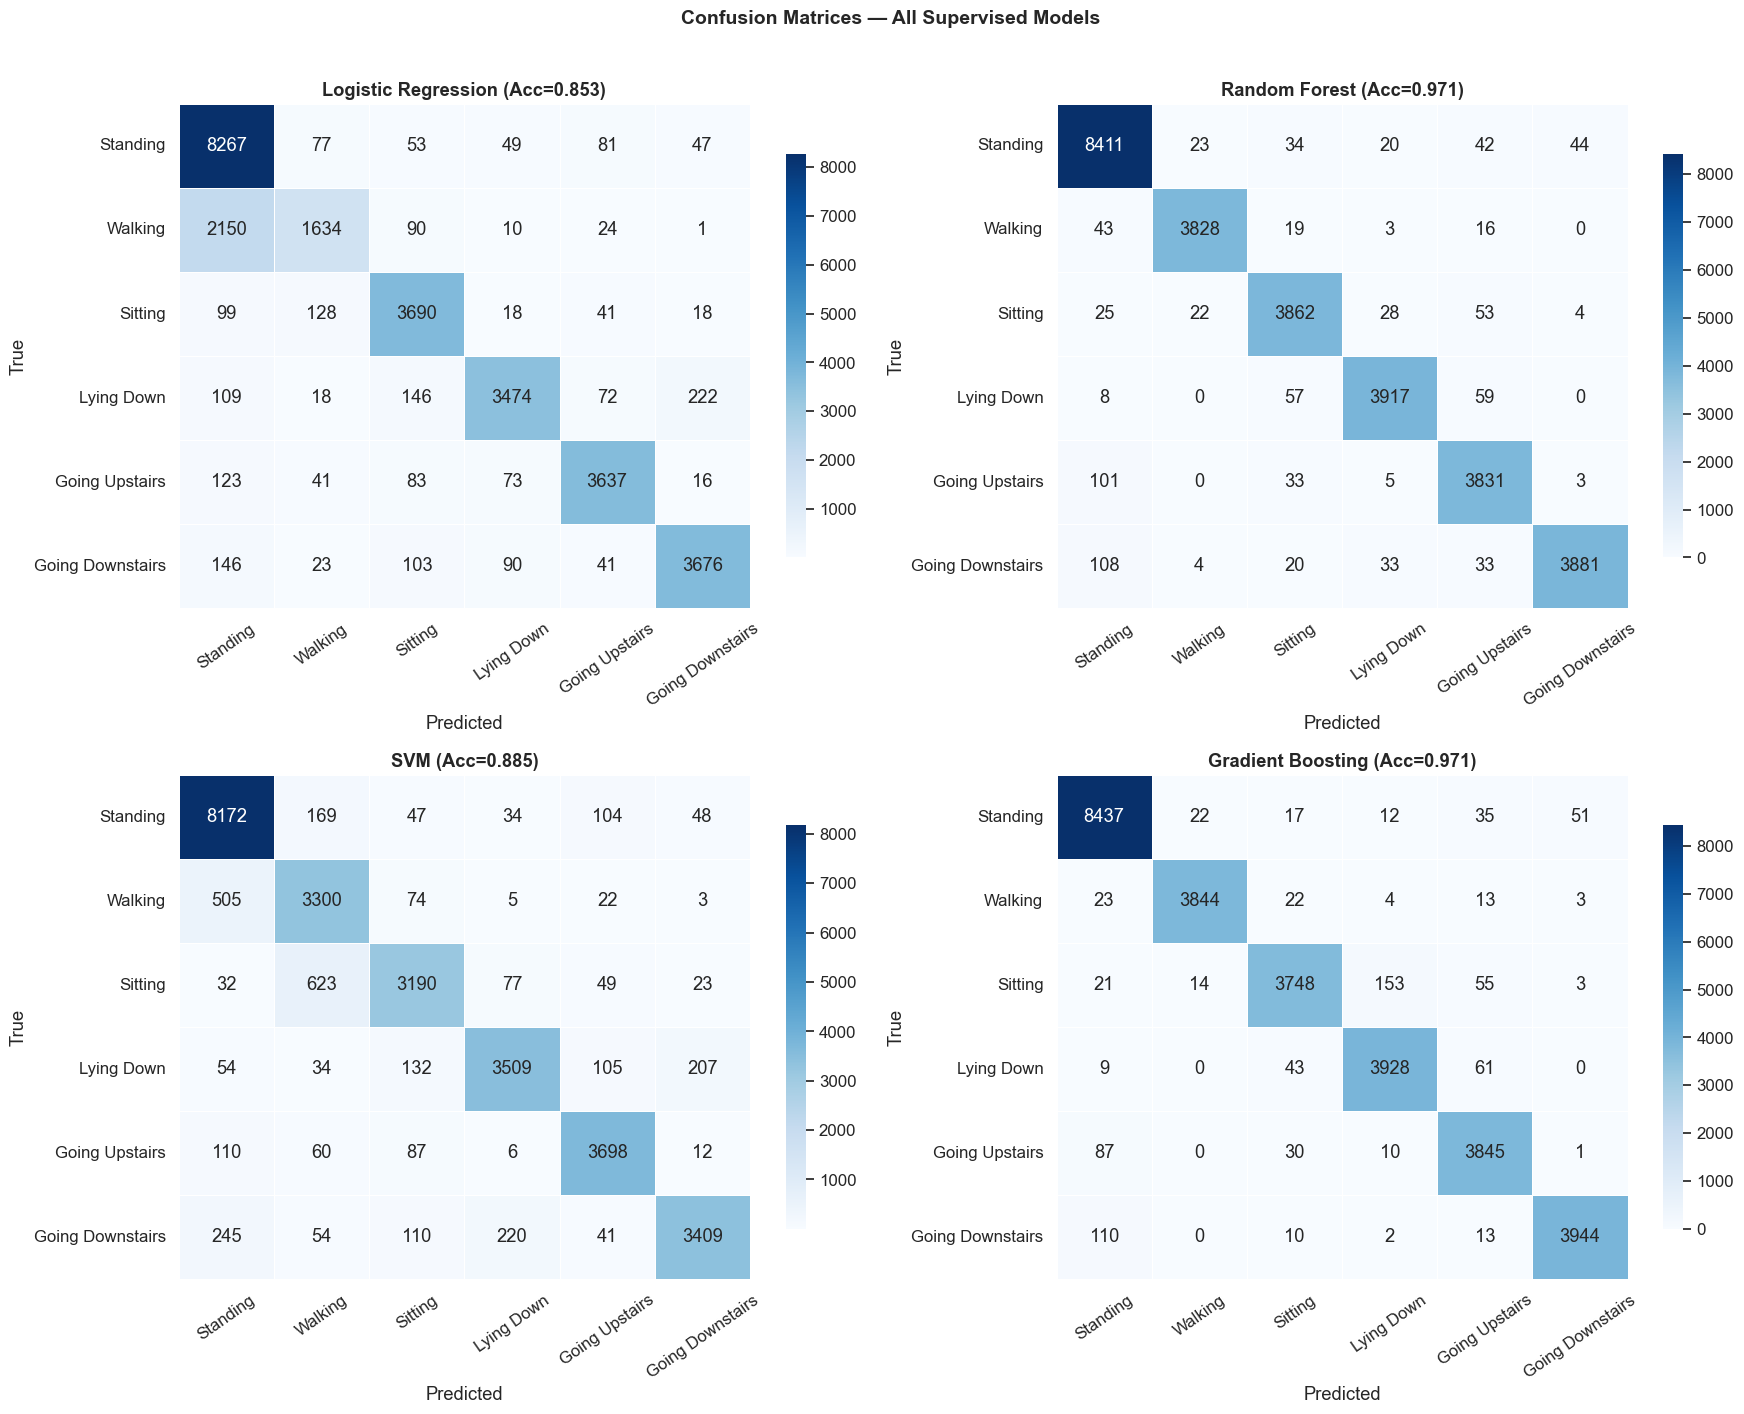

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for ax, result in zip(axes.flat, results):
    plot_confusion_matrix(y_test, result['y_pred'],
                          f"{result['name']} (Acc={result['test_acc']:.3f})", ax=ax)

plt.suptitle('Confusion Matrices — All Supervised Models', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('confusion_matrices_supervised.png', dpi=150, bbox_inches='tight')
plt.show()

## 6.5 — Feature Importance (Random Forest & Gradient Boosting)

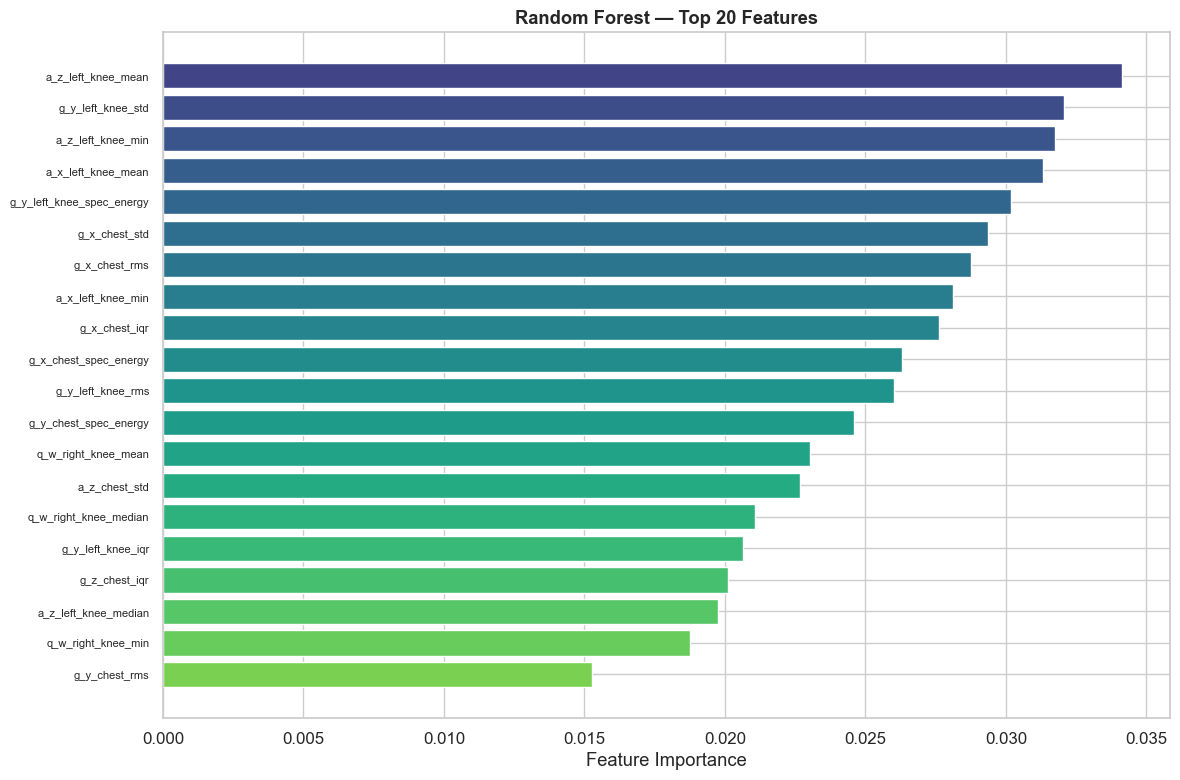

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 20

# Only Random Forest has straightforward feature_importances_ with column names
rf_result = [r for r in results if r['name'] == 'Random Forest'][0]
model = rf_result['model']
importances = model.feature_importances_
feat_names = X_train.columns

idx_top = np.argsort(importances)[-top_n:][::-1]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
ax.barh(range(top_n), importances[idx_top][::-1], color=colors[::-1])
ax.set_yticks(range(top_n))
ax.set_yticklabels(feat_names[idx_top][::-1], fontsize=8)
ax.set_xlabel('Feature Importance')
ax.set_title(f'Random Forest — Top {top_n} Features', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_supervised.png', dpi=150, bbox_inches='tight')
plt.show()


## 6.6 — Model Comparison Table

In [6]:
comparison_df = pd.DataFrame([{
    'Model': r['name'],
    'CV Accuracy': f"{r['cv_mean']:.4f} ± {r['cv_std']:.4f}",
    'Test Accuracy': f"{r['test_acc']:.4f}",
    'Test F1 (weighted)': f"{r['test_f1']:.4f}",
    'Train Time (s)': f"{r['train_time']:.1f}"
} for r in results])

print('\n' + '='*80)
print('MODEL COMPARISON')
print('='*80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('model_comparison_supervised.csv', index=False)

# Highlight best
best_idx = np.argmax([r['test_acc'] for r in results])
print(f'\n🏆 Best model: {results[best_idx]["name"]} '
      f'(Test Accuracy: {results[best_idx]["test_acc"]:.4f})')


MODEL COMPARISON
              Model     CV Accuracy Test Accuracy Test F1 (weighted) Train Time (s)
Logistic Regression 0.8497 ± 0.0081        0.8533             0.8435            8.8
      Random Forest 0.9579 ± 0.0028        0.9706             0.9706           12.1
                SVM 0.8762 ± 0.0056        0.8848             0.8845           12.9
  Gradient Boosting 0.9717 ± 0.0032        0.9712             0.9711            9.3

🏆 Best model: Gradient Boosting (Test Accuracy: 0.9712)


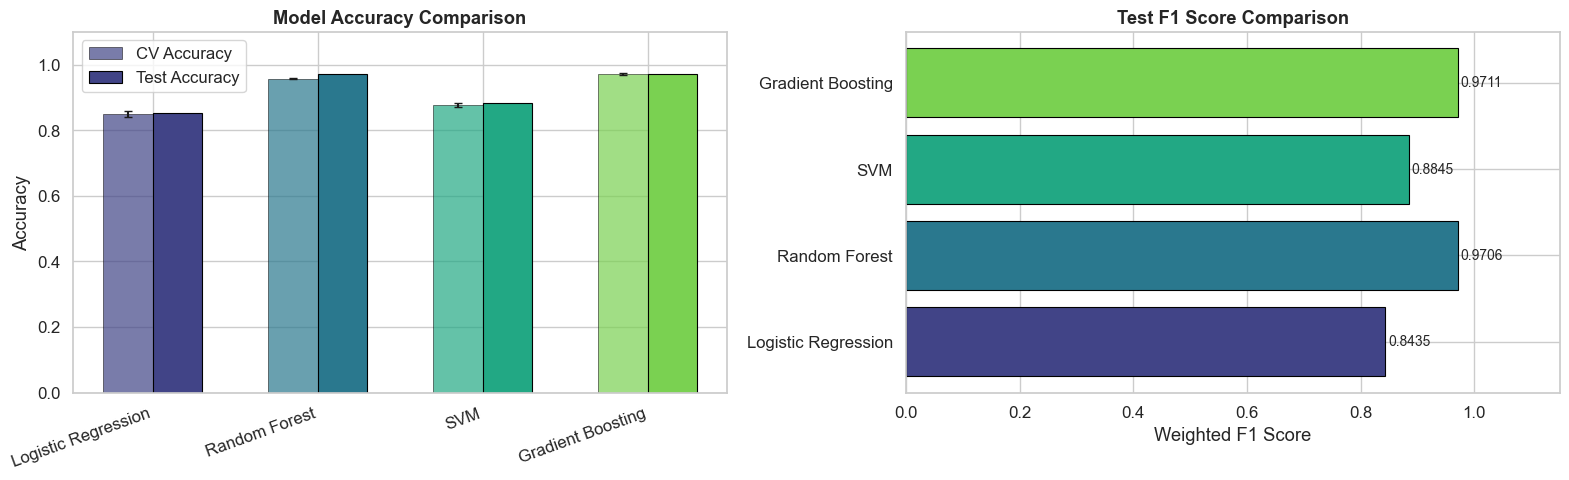

In [7]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

names = [r['name'] for r in results]
test_accs = [r['test_acc'] for r in results]
test_f1s = [r['test_f1'] for r in results]
cv_means = [r['cv_mean'] for r in results]
cv_stds = [r['cv_std'] for r in results]

colors = sns.color_palette('viridis', len(results))

# Accuracy comparison
x = np.arange(len(names))
axes[0].bar(x - 0.15, cv_means, 0.3, label='CV Accuracy', color=colors, alpha=0.7,
            yerr=cv_stds, capsize=3, edgecolor='black', linewidth=0.5)
axes[0].bar(x + 0.15, test_accs, 0.3, label='Test Accuracy', color=colors,
            edgecolor='black', linewidth=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(names, rotation=20, ha='right')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# F1 comparison
axes[1].barh(names, test_f1s, color=colors, edgecolor='black', linewidth=0.8)
axes[1].set_xlabel('Weighted F1 Score')
axes[1].set_title('Test F1 Score Comparison', fontweight='bold')
for i, v in enumerate(test_f1s):
    axes[1].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)
axes[1].set_xlim(0, 1.15)

plt.tight_layout()
plt.savefig('model_comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

## 6.7 — Save Models

In [8]:
for result in results:
    model_path = MODEL_DIR / f"{result['name'].replace(' ', '_').lower()}.joblib"
    joblib.dump(result['model'], model_path)
    print(f'Saved: {model_path}')

print(f'\n✅ All models saved to {MODEL_DIR}/')

Saved: models\logistic_regression.joblib
Saved: models\random_forest.joblib
Saved: models\svm.joblib
Saved: models\gradient_boosting.joblib

✅ All models saved to models/


## 6.8 — Summary

**Key findings:**
- All supervised models significantly outperform unsupervised clustering (Notebook 05).
- Tree-based models (Random Forest, Gradient Boosting) tend to perform best due to their
  ability to model non-linear decision boundaries without explicit feature engineering.
- SVM with RBF kernel is competitive but slower to train.
- Logistic Regression provides a strong baseline despite being linear.
- Dynamic activities (walking, stairs) are generally easier to classify than
  distinguishing between static activities (standing vs sitting).

**Next:** Hyperparameter tuning in `07_Hyperparameter_Tuning.ipynb`.